### Compiling a Pytorch SSD Mobilenet v3 lite with SageMaker Neo

In this example you'll see how to get a public implementation of a Pytorch SSD Mobilent V3 and prepare it for a Neo compilation. The target is a Linux x86_64, but you can also compile it for a Jetson based device.

In [ ]:
!pip3 install -U torch==1.8.0 torchvision

## 1 Clone the model implementation repo

In [2]:
!git clone https://github.com/shaoshengsong/MobileNetV3-SSD && \
    cd MobileNetV3-SSD && git checkout 6a406b22dbfee84bcb6de46b684c3138051cf318

Cloning into 'MobileNetV3-SSD'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 114 (delta 2), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (114/114), 150.07 KiB | 1.06 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Checking out files: 100% (55/55), done.
Note: checking out '6a406b22dbfee84bcb6de46b684c3138051cf318'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 6a406b2 Update README.md


## 2 - Get an image and make an input tensor with it

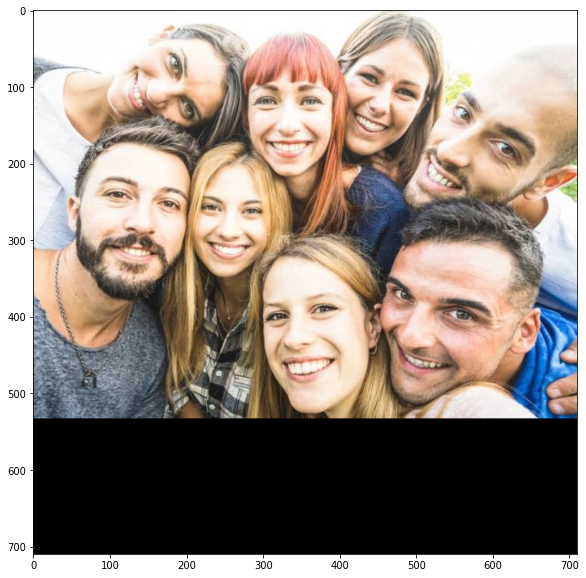

In [3]:
%matplotlib inline
import os
import cv2
import torch
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

if not os.path.isfile('people.jpg'):
    url="http://vendas3i.com.br/wp-content/uploads/2015/11/atracao-contratacao-desenvolvimento-retencao-e-demissao-1014x487.jpg"
    urllib.request.urlretrieve(url, 'people.jpg')

img = cv2.imread('people.jpg')
h,w,c=img.shape
if h!=w: # make it squared
    max_side = max(h,w)
    img_ = np.zeros((max_side,max_side,c), dtype=np.uint8)
    img_[:h,:w],img = img,img_
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(img)

## 3 - Download pre-trained model weights

In [13]:
import io
import tarfile
import urllib.request

url='https://spock.cloud/models/pytorch_ssd_mobilenet_v3_lite.tar.gz'
with urllib.request.urlopen(url) as f:
    with tarfile.open(mode='r:gz', fileobj=io.BytesIO(f.read())) as tar:
        tar.extractall()

## 4 - Load/run the model

In [23]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
sys.path.insert(0,'MobileNetV3-SSD')
from vision.ssd.mobilenet_v3_ssd_lite import create_mobilenetv3_ssd_lite, create_mobilenetv3_ssd_lite_predictor

label_path='voc-model-labels.txt'
class_names = [name.strip() for name in open(label_path).readlines()]
model = create_mobilenetv3_ssd_lite(len(class_names), is_test=True)
model.load('mb3-ssd-lite-Epoch-149-Loss-5.782852862012213.pth')
model.eval()
predictor = create_mobilenetv3_ssd_lite_predictor(model, 200)

In [24]:
from vision.utils import box_utils
boxes,labels,probs = predictor.predict(img, 10, 0.16)
print(len(boxes))

Inference time:  0.02410721778869629
3


### Attention - The model performance is really bad at people
You need to retrain the model to get better results

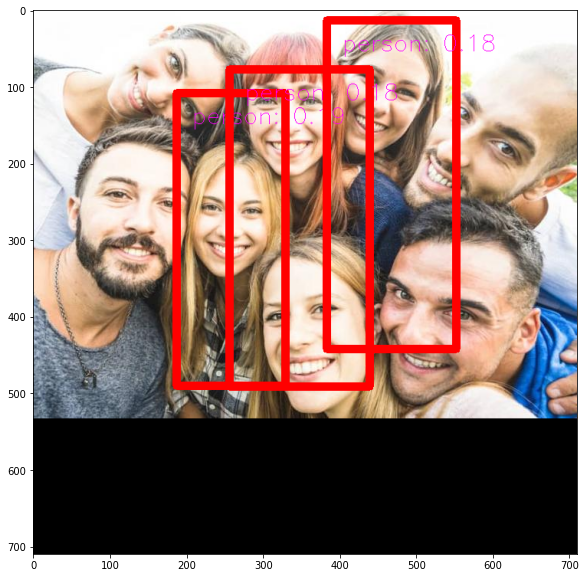

In [25]:
img_ = img.copy()
h,w,c = img_.shape
for bbox,score,label in zip(boxes,probs,labels):
    x1,y1,x2,y2 = bbox.detach().numpy().astype(np.int32)
    cv2.rectangle(img_, (x1,y1), (x2,y2), (255,0,0), 10)
    label = f"{class_names[label]}: {score:.2f}"
    cv2.putText(img_, label,
                (x1 + 20, y1 + 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,  # font scale
                (255, 0, 255),
                1)  # line type    
plt.figure(figsize=(20,10))
plt.imshow(img_)

## 5 - Now, trace the model, updload it to S3 and run a SageMaker Neo Compilation Job

In [21]:
with torch.no_grad():
    inp = torch.rand(1,3,300,300)
    traced_model = torch.jit.trace(model, inp, strict=False)
    traced_model.save('ssd_mobilenet_v3_lite.pth')

In [22]:
import io
import tarfile
import sagemaker

model_name='ssd-lite-mobilenet-v3-lite'
img_size=300
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
with io.BytesIO() as f:
    with tarfile.open(fileobj=f, mode="w:gz") as tar:
        tar.add('ssd_mobilenet_v3_lite.pth')
        tar.list()
    f.seek(0)
    s3_uri = sagemaker_session.upload_string_as_file_body(f.read(), default_bucket, f"models/{model_name}/model.tar.gz")
    print(s3_uri)

-rw-r--r-- root/root   12546116 2022-02-25 16:14:01 ssd_mobilenet_v3_lite.pth 
s3://sagemaker-us-east-1-715445047862/models/ssd-lite-mobilenet-v3-lite/model.tar.gz


In [ ]:
import time
import boto3
import sagemaker

arch='X86_64' # Jetson = ARM64
role = sagemaker.get_execution_role()
sm_client = boto3.client('sagemaker')
compilation_job_name = f'{model_name}-pytorch-{int(time.time()*1000)}'
sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': s3_uri,
        'DataInputConfig': f'{{"input": [1,3,{img_size},{img_size}]}}',
        'Framework': 'PYTORCH',        
    },
    OutputConfig={
        'S3OutputLocation': f's3://{default_bucket}/{model_name}-pytorch/optimized/',
        'TargetPlatform': { 
            'Os': 'LINUX', 
            'Arch': arch,
            #'Accelerator': 'NVIDIA'  # comment this if you don't have an Nvidia GPU
        },
        # Comment or change the following line depending on your edge device
        # Jetson Xavier: sm_72; Jetson Nano: sm_53
        #'CompilerOptions': '{"trt-ver": "7.1.3", "cuda-ver": "10.2", "gpu-code": "sm_72"}' # Jetpack 4.4.1
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 18000 }
)
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(5)